# Homework 5
## USA Graph
### Methodology
We construct a graph of the United States based on real geographical borders. Each state is represented as a SIR Node with its own three compartments: S, I, R. Whenever two states share a border, there is an edge between them. The only two states that are isolated are Hawaii and Alaska. So those two states are dropped. Washington DC is also counted as a state.

Each every time step, there is a migration between neighboring states. The migration rate $\alpha$ is effectively a gain parameter, determining the connectivity between states. When $\alpha=0$, there is no migration so each state just evolves independently. At every unit time step, a $\alpha$ fraction of the current state (say MA) will migrate to each of its neighboring state (Connecticut, Vermont, New Hamsphere, Rhode Islands, and New York). Then after migration takes effect, we evolves each state normally according to the SIR model
$$\dot{S} = -\beta S I$$
$$\dot{I} = \beta S I - \mu I$$
$$\dot{R} = -\mu I$$
with new demographics $S, I, R$.

The population of each state is also taken to be realistic from Internet's data. Recall from last HW4 that the infectious rate $\beta = (\kappa * \tau)/N$ where $\kappa$ is the number of daily contacts of an individual, $\tau$ is the transmibility of the disease and $N$ is the state population. Thus, we need to take care to update $\beta$ for each state during each evolution time step since their population size $N$ constantly changes due to migration. In , we pick different $\alpha$, visualize the population dynamics of USA and keep track of the epidemics within MA.

Originally, we only have two infected cases in the coasts: NY and CA.

### Extension
For simplicity, we consider deterministic migration. One easy extension is to consider $\alpha$ as the probability that each individual migrates. So each individual in MA has $\alpha$ probability of going migrate. Given that an individual migrate, we pick their destination uniformly out of the neighbors. The number of migrations for each state is thus a geometric random variable (coin toss: head = migration, tail = stays in place). 

Right now, we only allow migration between neighboring states. This is somewhat reasonable since long-distance travel like airplane or bus in an epidemic is usually limited. But one extension we can make is to allow migration between any nodes that has a path between them. The migration rate should be inversely proportional to the shortest distance between two nodes. We still maintain a global average $\alpha$ rate as a parameter of the model. So migration rate between $x, y$ would be $\alpha/(|x-y|)$ where $|x-y|$ means the length of the shortest path in the graph between those nodes.

## Degree-based mean field theory (DBFT)
We also consider a random graph approach. Here, we follows "Epidemic Spreading in Scale-Free Networks" by Romualdo Pastor-Satorras1 and Alessandro Vespignani 2001.

We use the Barabási–Albert model. This is a model similar to human-made systems like social networks (Twitter, Facebook) or webpage connections (world wide web) and biological systems in the wild. The key idea is preferential attachment: when a new member joins Facebook, she would most likely be acquainted and be friend with the current most visible members. That is nodes that already have large number of connections (large degree) will be more likely to receive a connection from a newly created nodes.

In Barabási–Albert, we have two parameters: $n$ -- total number of nodes and $m$ -- the number of friend requests that a newly created node will send to already-there nodes. Initially, we create a small empty graph of $m_0 << n$ nodes. Then, subsequently, we create a new node, seeking to add $m$ connections. The probability of connecting to a already-there node $i$ is directly proportional to the degree of $i$ .i.e. $\sim k_i / \sum_j k_j$ where $k_i$ is degree of $i$.

This is a power-law random graph as opposed to exponential graph like Erdos. In Erdos, the degree distribution centers at the average degree $<k>$ and exponentially decay away from $<k>$. Here, the probability of seeing $k$-degree node (the fraction of $k$-degree nodes in the graph), $P(k)$ is $\sim k^{-3}$, which is a power exponent (hence the name).

The mean degree $<k> \sim 2m$ so $m$ is our gain parameter. Larger $m$ means denser graph. In degree-based mean field, we focus on the degree of a node. We assume that every node of the same degree is statiscally distinguishable (there's also individual-based mean field that focuses on each node). We let $p_k(t)$ be the fraction of $k$-degree nodes that are infected at time $t$. We assume a SIS dynamics since it is simpler than SIR. The governing ODE is
$$\partial_t p_k(t) = -p_k(t) + \lambda k (1 - p_k(t)) \Theta(\lambda).$$
The first term is the usual recovery rate. The second term is infection. $(1-p_k(t))$ is the fraction still susceptible. $\lambda$ is the infection rate. The factor $k$ is to speak to the fact that these nodes all have $k$ connections. So the higher $k$, the more exposure and higher chance of infection. $\theta(\lambda)$ is the probability that any connection becomes infectious. We have
$$
\theta(\lambda) = \sum_{k'} P(k' | k) p_{k'}(t)
$$
where $P(k' | k)$ is the probability that an edge originating from a k-degree node comes to a k'-degree node. We assume that the graph is "uncorrelated" so that $P(k'|k)$ only depends on the destination vertex. Then, $$P(k' | k) = \frac{k'P(k') N}{<k> N}$$
 so the numerator is the number of edges pointing the k-degree group and the denominator is the total number of edges. Then, 
 $$
 \theta(\lambda) = \sum_k \frac{k P(k)}{<k>} p_k(t)
 $$
 This ODE can be solved analytically. But here, we run numerical simulations varying $m$.
 
 The infection part should read: the chance that a susceptible $k$ (i.e. $1-p_k(t)$) comes into contact with a $k'$ individual (times $P(k'|k)$) who is infectious (times $p_{k'}(t)$) and the contact through one of the channels (times $k$) and the contact becomes infectious (times $\lambda$ the transmibility of the disease).

## USA CODE

In [25]:
## LIBRARIES 
from scipy.integrate import odeint
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from collections import defaultdict, Counter

In [2]:
## SIR NODE IN THE GRAPH
class SIRNode:
    def __init__(self, S, I, R, mig_rate):
        self.S = S
        self.I = I
        self.R = R
        self.mig_rate = mig_rate
        
    def grad(self, y, t):
        N = self.S + self.I + self.R
        beta = (kappa * tau)/N
        S, I, R = y
        dS = - beta * I * S
        dI = beta * I * S - mu * I
        dR = mu * I
        return dS, dI, dR 
    def step(self):
        #print('before', self.S, self.I, self.R)
        y0 = [self.S, self.I, self.R]
        S, I, R = odeint(self.grad, y0, dt).T
        self.S, self.I, self.R = S[-1], I[-1], R[-1]
        #print(S, I, R)
        #print('after', self.S, self.I, self.R)
    #def migrate_to(self, neighNode):
    #    dS, dI, dR = self.mig_rate*self.S, self.mig_rate*self.I, self.mig_rate*self.R
    #    self.S -= dS
    #    self.R -= dR
    #    self.I -= dI
    #    neighNode.S += dS
    #    neighNode.R += dR
    #    neighNode.I += dI

In [3]:
# Helper functions
def step_network(G):
    for node in G:
        G.node[node]['population'].step()

In [4]:
# asynchronous update
#def migrate(G):
#    # from node migrate to neighbors
#    migs = defaultdict(float)
#    for node, neighs in G._adj.items(): 
#        num_neighs = len(neighs)
#        for neigh in neighs:
#            G.node[node]['population'].migrate_to(G.node[neigh]['population'])

# synchrnous update


def migrate(G):
    # from node migrate to neighbors
    migs_S = defaultdict(float)
    migs_I = defaultdict(float)
    migs_R = defaultdict(float)
    # subtract migs
    for node, neighs in G._adj.items(): 
        state_node = G.node[node]['population']
        dS = state_node.S * state_node.mig_rate
        dI = state_node.I * state_node.mig_rate
        dR = state_node.R * state_node.mig_rate
        state_node.S -= dS
        state_node.I -= dI
        state_node.R -= dR
        
        for neigh in neighs:
            migs_S[neigh] += dS/len(neighs)
            migs_I[neigh] += dI/len(neighs)
            migs_R[neigh] += dR/len(neighs)
            
    for node in G:
        state_node = G.node[node]['population']
        state_node.S += migs_S[node]
        state_node.I += migs_I[node]
        state_node.R += migs_R[node]
        
        

In [5]:
def network_stats(G):
    Ss, Rs, Is = {}, {}, {}
    for node in G:
        Ss[node] = G.node[node]['population'].S
        Is[node] = G.node[node]['population'].I
        Rs[node] = G.node[node]['population'].R
        #Ss.append(G.node[node]['population'].S)
        #Is.append(G.node[node]['population'].I)
        #Rs.append(G.node[node]['population'].R)
    return Ss, Is, Rs

In [6]:
## SIMULATION CONFIGS

#N = 37819 # Amherst population
t = 60 # simulation days
mu = 1 /14  # 14 days to recover
kappa = 10 # meet about 10 people a day
tau = 0.05 
#S0, I0, R0 = N-1, 1, 0
RR0 = kappa * tau * (1/mu)
dt = [1, 2] # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
# evolves the dynamics for one time point

In [7]:
# https://www.101computing.net/us-population/
populations =  '''
Alabama,AL,4447100
Arizona,AZ,5130632
Arkansas,AR,2673400
California,CA,33871648
Colorado,CO,4301261
Connecticut,CT,3405565
Delaware,DE,783600
Florida,FL,15982378
Georgia,GA,8186453
Idaho,ID,1293953
Illinois,IL,12419293
Indiana,IN,6080485
Iowa,IA,2926324
Kansas,KS,2688418
Kentucky,KY,4041769
Louisiana,LA,4468976
Maine,ME,1274923
Maryland,MD,5296486
Massachusetts,MA,6349097
Michigan,MI,9938444
Minnesota,MN,4919479
Mississippi,MS,2844658
Missouri,MO,5595211
Montana,MT,902195
Nebraska,NE,1711263
Nevada,NV,1998257
New Hampshire,NH,1235786
New Jersey,NJ,8414350
New Mexico,NM,1819046
New York,NY,18976457
North Carolina,NC,8049313
North Dakota,ND,642200
Ohio,OH,11353140
Oklahoma,OK,3450654
Oregon,OR,3421399
Pennsylvania,PA,12281054
Rhode Island,RI,1048319
South Carolina,SC,4012012
South Dakota,SD,754844
Tennessee,TN,5689283
Texas,TX,20851820
Utah,UT,2233169
Vermont,VT,608827
Virginia,VA,7078515
Washington,WA,5894121
Washington D.C.,DC,572059
West Virginia,WV,1808344
Wisconsin,WI,5363675
Wyoming,WY,493782
'''
populations = populations.split('\n')[1:-1]
pop_dict = {}
max_N = 0 
for line in populations:
    line = line.split(',')
    state, population = line[1], int(line[2])
    pop_dict[state] = population
    max_N = max(max_N, population)


In [8]:
# sources of infection
sources = ['CA', 'NY']
def init_network(G,mig_rate):
    for i in G:
        N = pop_dict[i]
        if i in sources:
            S0, I0, R0 = N-1, 1, 0
        else:
            S0, I0, R0 = N, 0, 0
        G.node[i]['population'] = SIRNode(S0, I0, R0, mig_rate)

In [9]:
# DOES NOT WORK. USA MAP NOT PLANAR FOR SOME REASONS...
# Author Gregg Lind
# License:  Public Domain.    I would love to hear about any projects you use if it for though!
#states = '''
#AK
#AL,MS,TN,GA,FL
#AR,MO,TN,MS,LA,TX,OK
#AZ,CA,NV,UT,CO,NM
#CA,OR,NV,AZ
#CO,WY,NE,KS,OK,NM,AZ,UT
#CT,NY,MA,RI
#DE,MD,PA,NJ
#FL,AL,GA
#GA,FL,AL,TN,NC,SC
#HI
#IA,MN,WI,IL,MO,NE,SD
#ID,MT,WY,UT,NV,OR,WA
#IL,IN,KY,MO,IA,WI
#IN,MI,OH,KY,IL
#KS,NE,MO,OK,CO
#KY,IN,OH,WV,VA,TN,MO,IL
#LA,TX,AR,MS
#MA,RI,CT,NY,NH,VT
#MD,VA,WV,PA,DE
#ME,NH
#MI,WI,IN,OH
#MN,WI,IA,SD,ND
#MO,IA,IL,KY,TN,AR,OK,KS,NE
#MS,LA,AR,TN,AL
#MT,ND,SD,WY,ID
#NC,VA,TN,GA,SC
#ND,MN,SD,MT
#NE,SD,IA,MO,KS,CO,WY
#NH,VT,ME,MA
#NJ,DE,PA,NY
#NM,AZ,UT,CO,OK,TX
#NV,ID,UT,AZ,CA,OR
#NY,NJ,PA,VT,MA,CT
#OH,PA,WV,KY,IN,MI
#OK,KS,MO,AR,TX,NM,CO
#OR,CA,NV,ID,WA
#PA,NY,NJ,DE,MD,WV,OH
#RI,CT,MA
#SC,GA,NC
#SD,ND,MN,IA,NE,WY,MT
#TN,KY,VA,NC,GA,AL,MS,AR,MO
#TX,NM,OK,AR,LA
#UT,ID,WY,CO,NM,AZ,NV
#VA,NC,TN,KY,WV,MD
#VT,NY,NH,MA
#WA,ID,OR
#WI,MI,MN,IA,IL
#WV,OH,PA,MD,VA,KY
#WY,MT,SD,NE,CO,UT,ID
#''' 
#states = states.split('\n')[1:-1]

In [10]:
# source: https://www-cs-faculty.stanford.edu/~knuth/contiguous-usa.dat
states ='''
AL FL
AL GA
AL MS
AL TN
AR LA
AR MO
AR MS
AR OK
AR TN
AR TX
AZ CA
AZ NM
AZ NV
AZ UT
CA NV
CA OR
CO KS
CO NE
CO NM
CO OK
CO UT
CO WY
CT MA
CT NY
CT RI
DC MD
DC VA
DE MD
DE NJ
DE PA
FL GA
GA NC
GA SC
GA TN
IA IL
IA MN
IA MO
IA NE
IA SD
IA WI
ID MT
ID NV
ID OR
ID UT
ID WA
ID WY
IL IN
IL KY
IL MO
IL WI
IN KY
IN MI
IN OH
KS MO
KS NE
KS OK
KY MO
KY OH
KY TN
KY VA
KY WV
LA MS
LA TX
MA NH
MA NY
MA RI
MA VT
MD PA
MD VA
MD WV
ME NH
MI OH
MI WI
MN ND
MN SD
MN WI
MO NE
MO OK
MO TN
MS TN
MT ND
MT SD
MT WY
NC SC
NC TN
NC VA
ND SD
NE SD
NE WY
NH VT
NJ NY
NJ PA
NM OK
NM TX
NV OR
NV UT
NY PA
NY VT
OH PA
OH WV
OK TX
OR WA
PA WV
SD WY
TN VA
UT WY
VA WV
'''

states = states.split('\n')[1:-1]

In [11]:
#def init_USA():
#    USA = {}
#    for group in states:
#        group = group.split(' ')'
#        state, neighbors = group[0], group[1:]
#        #print('state:', state)
#        #USA[state] = neighbors
#    return nx.Graph(USA)


def init_USA():
    G = nx.Graph()
    for line in states:
        A, B = line.split(' ')
        G.add_edge(A, B) 
    return G

In [12]:
# https://stackoverflow.com/questions/31815454/animate-graph-diffusion-with-networkx
# keep track of MA epidemics

class Simulation:
    def __init__(self, mig_rate):
        self.mig_rate = mig_rate
        self.G = init_USA()
        init_network(self.G, mig_rate)
        self.MA_S, self.MA_I, self.MA_R = [], [], []
        self.total_S, self.total_I, self.total_R = [], [], []
        
        #self.layout = nx.spring_layout(self.G, seed=2)
        self.layout = nx.drawing.layout.kamada_kawai_layout(self.G)
        # TODO: self.monitor to pass states to monitor

    

    
    def update(self, i):
        for ax in self.axes:
            ax.clear()

        Ss, Is, Rs = network_stats(self.G)
        styles = { 'pos': self.layout, 'with_labels' : True, 'vmin' : 0, 'vmax' : max_N,
            'alpha':0.8, 'style':'dashed'}

        self.MA_S.append(Ss['MA'])
        self.MA_I.append(Is['MA'])
        self.MA_R.append(Rs['MA'])
        self.total_S.append(sum(Ss.values()))
        self.total_I.append(sum(Is.values()))
        self.total_R.append(sum(Rs.values()))

        #nx.drawing.draw_kamada_kawai(self.G, node_color=list(Is.values()), cmap=plt.cm.Reds, 
        #        ax=self.axes[0], **styles)
        #nx.drawing.draw_kamada_kawai(self.G, node_color=list(Ss.values()), cmap=plt.cm.Blues, 
        #        ax=self.axes[1], **styles) 
        #nx.drawing.draw_kamada_kawai(self.G, node_color=list(Rs.values()), cmap=plt.cm.Greens, 
        #        ax=self.axes[2], **styles) 
        
        nx.draw(self.G, node_color=list(Is.values()), cmap=plt.cm.Reds, 
                ax=self.axes[0], **styles)
        nx.draw(self.G, node_color=list(Ss.values()), cmap=plt.cm.Blues, 
                ax=self.axes[1], **styles) 
        nx.draw(self.G, node_color=list(Rs.values()), cmap=plt.cm.Greens, 
                ax=self.axes[2], **styles) 

        # update network
        step_network(self.G)
        migrate(self.G)

        # Set the title
        self.axes[0].set_title("Day {} Infected".format(i))
        self.axes[1].set_title("Susceptible")
        self.axes[2].set_title("Recovered")
    
    def start(self):
        self.fig, self.axes = plt.subplots(3, 1, figsize=(10, 10))
        self.ani = FuncAnimation(self.fig, self.update,
                                 frames=t)
        plt.show()

In [13]:
def plot_state(s):
    plt.plot(s.MA_S, 'b', alpha=0.8, label='S')
    plt.plot(s.MA_I, 'r', alpha=0.8, label='I')
    plt.plot(s.MA_R, 'g', alpha=0.8, label='R')
    plt.xlabel('Day')
    plt.title('Epidemics in MA mig_rate ' + str(s.mig_rate))
    plt.legend()

    plt.show()

In [14]:
def plot_total(s):
    plt.plot(s.total_S, 'b', alpha=0.8, label='S')
    plt.plot(s.total_I, 'r', alpha=0.8, label='I')
    plt.plot(s.total_R, 'g', alpha=0.8, label='R')
    plt.xlabel('Day')
    plt.title('Epidemics in USA mig_rate ' + str(s.mig_rate))
    plt.legend()

    plt.show()

## USA Result

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


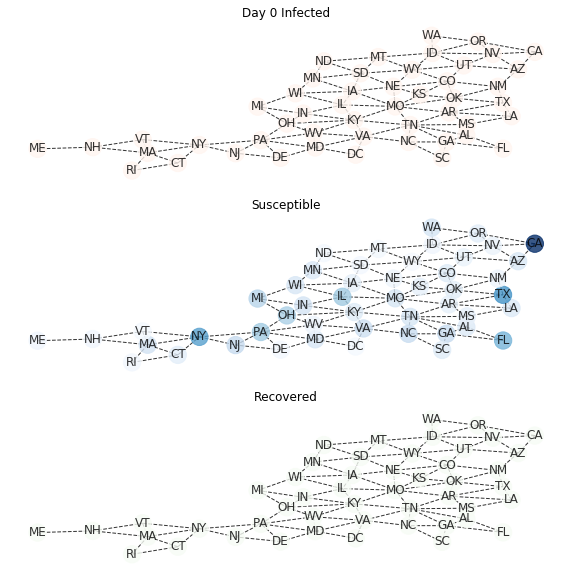

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


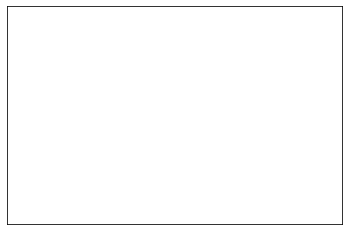

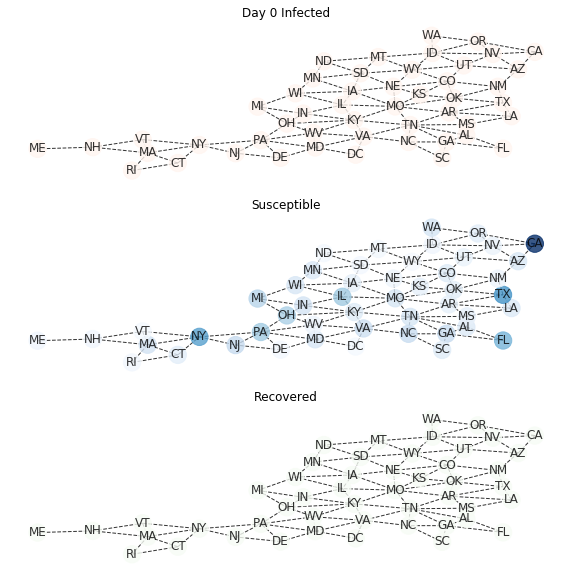

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


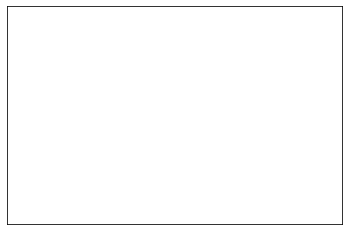

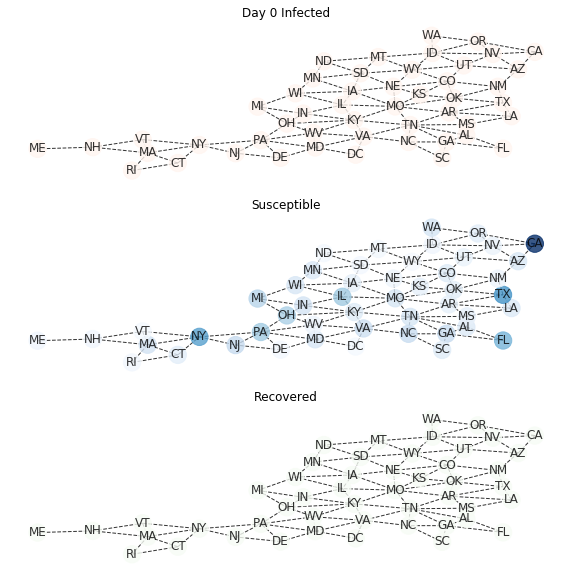

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


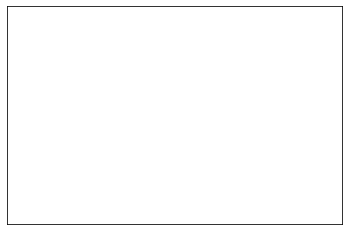

In [15]:
# gain parameters is the migration rate
Sims = []
for mig_rate in [0.05, 0.1, 0.8]:
    s = Simulation(mig_rate)
    s.start()
    # save simulation
    s.ani.save('network_' + str(mig_rate) + '.mp4')
    Sims.append(s)

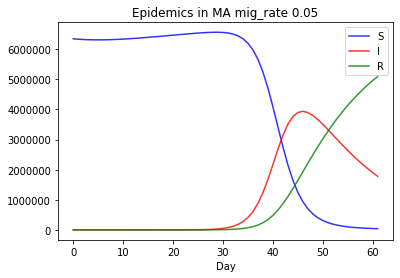

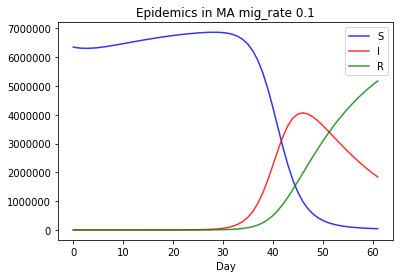

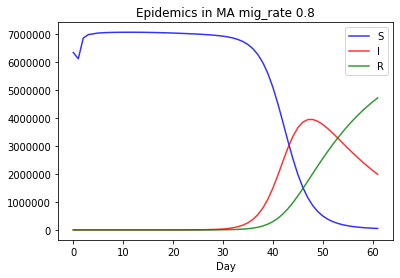

In [16]:
for s in Sims:
    plot_state(s)

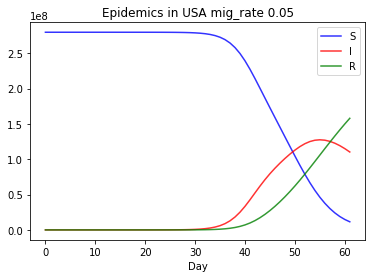

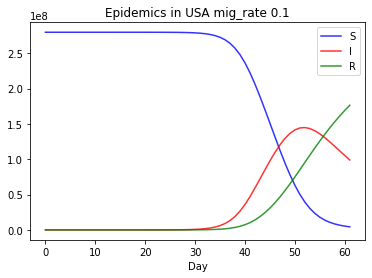

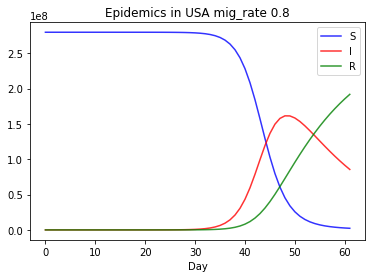

In [17]:
for s in Sims:
    plot_total(s)

Surprisingly, free movement does not seem to have an effect on the dynamics. For the entire USA, the four graphs look identical because the population size is so large, any small deviation would not be noticeable. Nonetheless, we can see the infected curve (red) for $\alpha=0.05$ is flatter compared to $ \alpha=0.8$ and peaks below 1.5 (hundred millions) compared to about $1.6$ for $\alpha=0.8$.

For MA, the different gain rates also do not have an effect on the dynamics. This is the short-comings of our model. In our model, people can only infect others living on the same state. So when someone infectious in MA moves else where, the population of infected in MA drops and fewer people would be subject to those moving-away infected people. On the other hand, infected people from other states can come to MA to infect as well. Somehow, there's a canceling effect and the four MA graphs look the same.

In the animations, we can clearly see the disease propogation from two intial sources. For example, at the beginning most states are not infectious (light orange) but towards the end, for large $\alpha$ almost all of them are mildly infectious (darker orange). This shows propagation in the network.

## Degree-based mean-field

In [326]:
n = 1000
lam = 0.1
m = 4

def albert_model(m):
    albert = nx.barabasi_albert_graph(n, m, seed=1)
    degs = [d for n, d in albert.degree()]
    degs = Counter(degs)
    P = np.zeros(max(degs)+1)
    for i in range(len(P)):
        P[i] = degs[i]/n
    k = np.array(range(max(degs)+1))
    k_avg = sum(P*k)
    print('average degree:', k_avg) # note that it's approximately 2m
    return albert, P, k, k_avg, degs

In [327]:
albert, P, k, k_avg, degs = albert_model(m)

average degree: 7.967999999999998


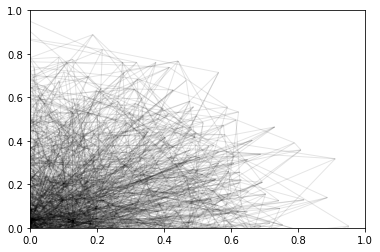

In [328]:
nx.draw_networkx_edges(albert, pos=nx.spring_layout(albert), alpha=0.1)
plt.show()

In [329]:
print('10-deg has ', k[10], 'nodes')
print('Max_deg:', max(degs), 'has', k[max(degs)], 'nodes')

10-deg has  10 nodes
Max_deg: 101 has 101 nodes


In [331]:
def theta_lam(pk, k, P, k_avg):
    return (k * P * pk) /k_avg

In [332]:
def DBMF_step(pk, t, k, P, k_avg):
    theta_L = sum(theta_lam(pk, k, P, k_avg))
    dpk = -pk + lam * k * (1 - pk) * theta_L
    return dpk

In [281]:
t = range(60) 
pks0 = np.zeros(max(degs)+1)
# initial infection
pks0[list(degs.keys())[2]] = 0.1
#DBMF_step(pks0, 0)
#for deg, num_nodes in degs.items():
#    y0[deg] = num_nodes
DBMF = odeint(DBMF_step, pks0, t, args=(k, P, k_avg))

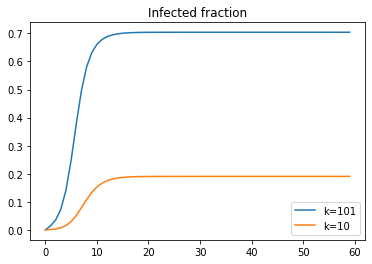

In [282]:
plt.plot(A[101], label='k=101')
plt.plot(A[10], label='k=10')
plt.title('Infected fraction')
plt.legend()
plt.show()

Clearly, lower degree means smaller chance of infection because there are fewer channels/ medium/connections for the disease (virus) and smaller chance of connecting to any other node. In the graph, $k=10$ is well below $k=101$. Now, let increase the average degree to get a more connected graph

In [333]:
albert2, P, k, k_avg, degs = albert_model(30)

average degree: 58.19999999999999


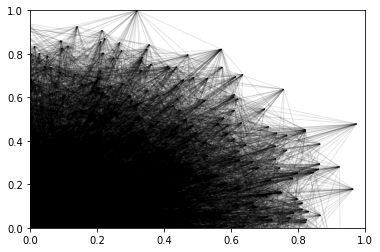

In [334]:
nx.draw_networkx_edges(albert2, pos=nx.spring_layout(albert2), alpha=0.1)
plt.show()

As advertised, the graph is much denser than the previous graph (darker edges).

In [335]:
print('10-deg has ', k[10], 'nodes')
print('Max_deg:', max(degs), 'has', k[max(degs)], 'nodes')

10-deg has  10 nodes
Max_deg: 280 has 280 nodes


In [341]:
t = range(60) 
pks0 = np.zeros(max(degs)+1)
# initial infection
pks0[list(degs.keys())[2]] = 0.1
#DBMF_step(pks0, 0)
#for deg, num_nodes in degs.items():
#    y0[deg] = num_nodes
DBMF = odeint(DBMF_step, pks0, t, args=(k, P, k_avg))

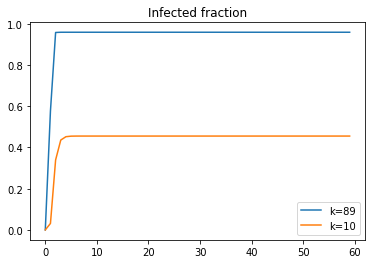

In [346]:
plt.plot(DBMF.T[280], label='k=280')
plt.plot(DBMF.T[10], label='k=10')
plt.title('Infected fraction')
plt.legend()
plt.show()

We can see with higher gain paramter, both curves ($k=10$ and $k=$max_degree) increase both faster and to higher rate compared to a sparse network with $m=4$.